<a href="https://colab.research.google.com/github/abdulrahman105/datascience/blob/main/2019aiml569_dl_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.listdir('/content/drive/MyDrive/dataset-face-mask/dataset')

['test', 'train_validate']

In [3]:
dataset_training_path = '/content/drive/MyDrive/dataset-face-mask/dataset/train_validate/'
dataset_test_path = '/content/drive/MyDrive/dataset-face-mask/dataset/test/'
os.listdir(dataset_training_path)

['unmasked', 'masked']

In [4]:
print("The number of images in training dataset with facemask    :",len(os.listdir(dataset_training_path + 'masked')))
print("The number of images in training dataset without facemask :",len(os.listdir(dataset_training_path + 'unmasked')))

The number of images in training dataset with facemask    : 887
The number of images in training dataset without facemask : 840


In [5]:
print("The number of images in test dataset with facemask    :",len(os.listdir(dataset_test_path + 'masked')))
print("The number of images in test dataset without facemask :",len(os.listdir(dataset_test_path + 'unmasked')))

The number of images in test dataset with facemask    : 160
The number of images in test dataset without facemask : 160


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics

In [7]:
print(tf.__version__)

2.4.0


In [8]:
import numpy as np
import os
import PIL
import PIL.Image

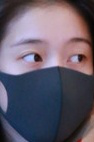

In [9]:
masked = os.listdir(dataset_training_path + 'masked')
PIL.Image.open(str(dataset_training_path + 'masked/' + masked[0]))

### Create a dataset
Define some parameters for the loader:

In [10]:
batch_size = 16
img_height = 64
img_width = 64

It's good practice to use a validation split when developing a model. We will use 80% of the images for training, and 20% for validation.

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_training_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1727 files belonging to 2 classes.
Using 1382 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_training_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1727 files belonging to 2 classes.
Using 345 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['masked', 'unmasked']


### Visualize the data
Here are the first 9 images from the training dataset.

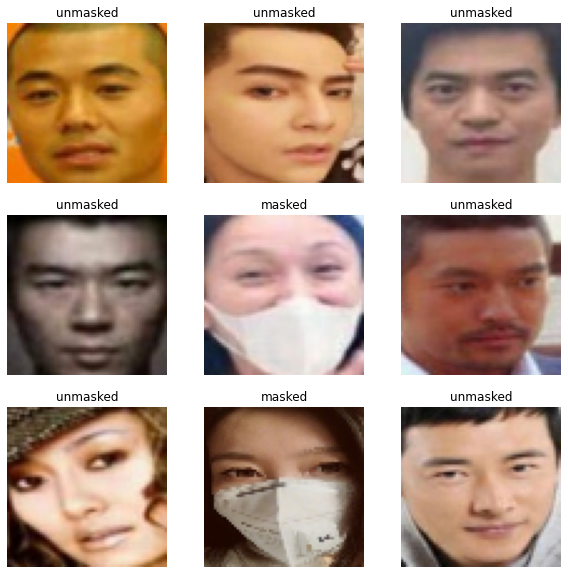

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 64, 64, 3)
(16,)


### Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make our input values small. Here, we will standardize values to be in the [0, 1] range by using a Rescaling layer in the model itself.
```
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
```



In [17]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### Compile the model
For this tutorial, choose the optimizers.Adam optimizer and losses.binary_crossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argum

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model summary
View all the layers of the network using the model's summary method:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

#### Train the model


In [20]:
epochs=70
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/70
87/87 [==============================] - 334s 803ms/step - loss: 0.5133 - accuracy: 0.7026 - val_loss: 0.1616 - val_accuracy: 0.9681
Epoch 2/70
87/87 [==============================] - 0s 5ms/step - loss: 0.1102 - accuracy: 0.9623 - val_loss: 0.2454 - val_accuracy: 0.9159
Epoch 3/70
87/87 [==============================] - 0s 4ms/step - loss: 0.1020 - accuracy: 0.9646 - val_loss: 0.1463 - val_accuracy: 0.9565
Epoch 4/70
87/87 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 0.9732 - val_loss: 0.1295 - val_accuracy: 0.9623
Epoch 5/70
87/87 [==============================] - 0s 4ms/step - loss: 0.0782 - accuracy: 0.9721 - val_loss: 0.1486 - val_accuracy: 0.9681
Epoch 6/70
87/87 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.9779 - val_loss: 0.1424 - val_accuracy: 0.9652
Epoch 7/70
87/87 [==============================] - 0s 4ms/step - loss: 0.0556 - accuracy: 0.9766 - val_loss: 0.1212 - val_accuracy: 0.9710
Epoch 8/70
87/87

### Visualize training results
Create plots of loss and accuracy on the training and validation sets.

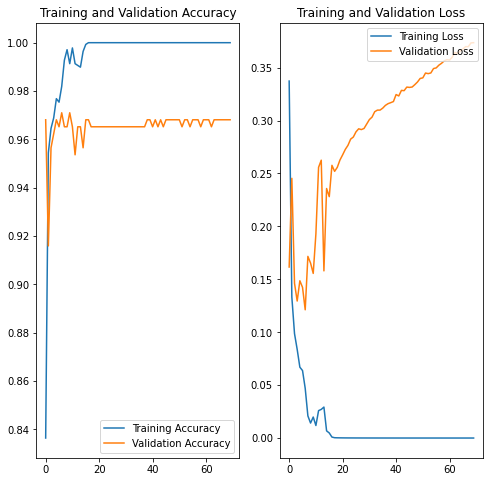

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data Augmentation
Overfitting generally occurs when there is a small number of training examples. Data augmentation takes the approach of generating additional training data from existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

I will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing.` These can be included inside the model like other layers.

In [22]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

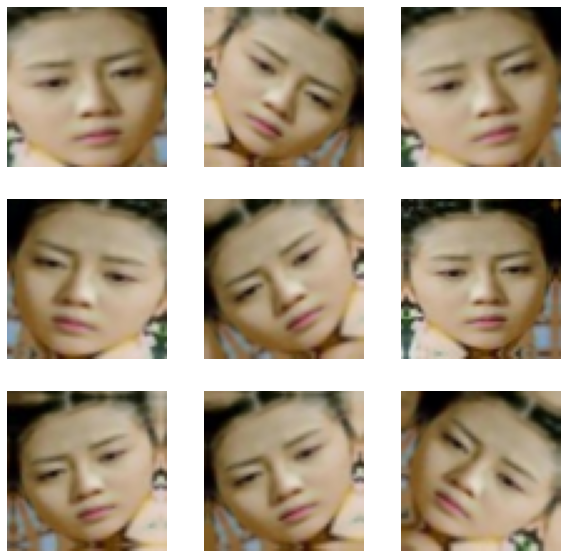

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout
Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Will create a new neural network using layers.Dropout, then train it using augmented images.

In [24]:
improved_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
improved_model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
improved_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)       

In [26]:
history = improved_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/70
87/87 [==============================] - 1s 7ms/step - loss: 0.5829 - accuracy: 0.6811 - val_loss: 0.1734 - val_accuracy: 0.9449
Epoch 2/70
87/87 [==============================] - 0s 5ms/step - loss: 0.1902 - accuracy: 0.9287 - val_loss: 0.1369 - val_accuracy: 0.9681
Epoch 3/70
87/87 [==============================] - 0s 5ms/step - loss: 0.1322 - accuracy: 0.9430 - val_loss: 0.1232 - val_accuracy: 0.9681
Epoch 4/70
87/87 [==============================] - 0s 5ms/step - loss: 0.1327 - accuracy: 0.9550 - val_loss: 0.1579 - val_accuracy: 0.9623
Epoch 5/70
87/87 [==============================] - 0s 5ms/step - loss: 0.0981 - accuracy: 0.9742 - val_loss: 0.1074 - val_accuracy: 0.9710
Epoch 6/70
87/87 [==============================] - 0s 5ms/step - loss: 0.0986 - accuracy: 0.9673 - val_loss: 0.1176 - val_accuracy: 0.9681
Epoch 7/70
87/87 [==============================] - 1s 6ms/step - loss: 0.0928 - accuracy: 0.9672 - val_loss: 0.1023 - val_accuracy: 0.9652
Epoch 8/70
87/87 [==

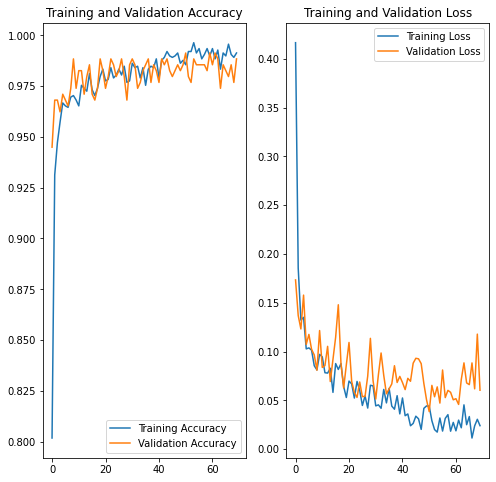

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(dataset_test_path, 
                                                  batch_size=batch_size, 
                                                  target_size=(img_height, img_width))

pred = model.predict(
    test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=0
)



Found 320 images belonging to 2 classes.


In [29]:
pred.shape

(320, 2)

In [30]:
model.metrics_names

['loss', 'accuracy']

In [31]:
improved_pred = improved_model.predict(
    test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=1
)

20/20 [==============================] - 1s 57ms/step


In [36]:

score = tf.nn.softmax(improved_pred[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to masked with a 100.00 percent confidence.
